In [1]:
import datetime as dt
import numpy as np
import SEB_functions as SEBf
import matplotlib.pyplot as plt


In [2]:
station = "S10"

if station == "S5":
    SEBdata = SEBf.SEB_data(FileName="PKM-data/S5_SEB_2003_2019_rp10b.txt")
    
elif station == "S6":
    SEBdata = SEBf.SEB_data(FileName="PKM-data/S6_SEB_2003_2019_rp4.txt")
    GsOld   = SEBdata.Extract_Variable("Gs")
    SEBdata.Correct_Gs_S6()

elif station == "S9":
    SEBdata = SEBf.SEB_data(FileName="PKM-data/S9_SEB_2003_2019_5.txt")
    
elif station == "S10":
    SEBdata = SEBf.SEB_data(FileName="PKM-data/S10_SEB_2009_2019.txt")


The header has  88 entries.
AWS file 'S10_SEB_2009_2019.txt' has 91776 lines of data for 84 variables, start reading it.
Reading completed.
No data corrections needed for this station.


In [3]:
# SWdown = SEBdata.Extract_Variable("SWin_corr")
# SWup   = SEBdata.Extract_Variable("SWout")
# SWnet  = SEBdata.Extract_Variable("SWnet_corr")
# LWdown = SEBdata.Extract_Variable("LWin")
# LWup   = SEBdata.Extract_Variable("LWout_corr")
# LWnet  = SEBdata.Extract_Variable("LWnet_model")
# SHF    = SEBdata.Extract_Variable("Hsen")
# LHF    = SEBdata.Extract_Variable("Hlat")
# Gs     = SEBdata.Extract_Variable("Gs")
# MeltS  = SEBdata.Extract_Variable("melt_energy") 
# MeltT  = SEBdata.Extract_Variable("totm_nrg") 
# Residu = SEBdata.Extract_Variable("rest_energy")

In [4]:
# if station == "S6":
#     # recover the "apparrent GsRec
#     SWint  = SEBdata.Extract_Variable("SumDivQ")
#     GsRec  = Gs - SWint - MeltS + MeltT


In [5]:
# #%%
# # Example plots of the SEB
# # OPTIONS HERE ARE
# # Typical yearly cycle -> AvgMonth
# # Monthly averages     -> Monthly
# # Daily averages       -> Daily





In [6]:
def find_LHF(T,P,RH2m,U10):
    '''Function to calculate the latent heat flux from the 2m temperature, pressure, relative humidity and wind speed'''
    mv = 18.0153 #g/mol
    mair = 28.9644 #g/mol

    if T <= 273.15:
        c_1 = 22.587
        c_2 = 273.68 #in C
    elif T > 273.15:
        c_1 = 17.502
        c_2 = 240.97 #in C
    else:
        return np.nan
    
    Qsat = 6.1121*mv/(P*mair)*np.exp(c_1*(T - 273.15)/(c_2+(T - 273.15))) #TODO Check if RH is in % 
    LHF =  U10 * ((RH2m-1)*Qsat) #TODO check if cl is one
    return LHF

In [7]:
def calc_Tsurf(T, P, RH2m, C_TBD,U10, SWadjnet, LWadjdown, SHF):
    '''Calculate the surface temperature from the bulk temperature and the wind speed'''
    sigma=5.67e-8
    LHF = find_LHF(T,P,RH2m,U10)
    
    c_adj = 4*(T**3)*sigma + C_TBD*U10
    c_fixed = SWadjnet + LWadjdown + 3*sigma*T**4 + SHF + C_TBD*U10*T - LHF 
    
    T_calced =  c_fixed/c_adj

    return T_calced

In [8]:
def calculate_melting(T,P,RH2m,U10,C_TBD,SWadjnet,LWadjdown,SHF):
    '''Function to calculate the melting energy from the surface temperature, pressure, relative humidity and wind speed''' 
    sigma= 5.67e-8
    LHF = find_LHF(T,P,RH2m,U10)

    c_adj = 4*(T**3)*sigma + C_TBD*U10
    c_fixed = SWadjnet + LWadjdown + 3*sigma*(T**4) + SHF + C_TBD*U10*T - LHF 
    M = (c_fixed-c_adj*T) #I think this shouldn't be negative for T > 273.15 but is. 
    return M


In [73]:
#TODO: Rewrite LWadjDown as function to convert from temperature to LWdown.

def LWadjdown(Tatm, dT):
    '''Function to convert temperature anomaly to LWdown'''
    #LW_in_T = SEBf.convert_LWout_in_T(-LW_down, Celcius=False)
    #T_fin = LW_in_T + dT
    LW_adj = SEBf.convert_T_in_LWout(Tatm + dT, Celcius=False)*-1
    return LW_adj

In [74]:
def get_variables(set_dT=False, dT=0):
    Tsurf = SEBdata.Extract_Variable("Tsurf_calc") + 273.15 #in degK
    # T_arr = Tsurf
    # LWout = SEBf.convert_T_in_LWout(Tsurf) 
    LWdown = SEBdata.Extract_Variable("LWin") #TODO: Convert LWDown to temperature function?
    SWnet = SEBdata.Extract_Variable('SWnet_corr')
    SWadjnet_arr = SWnet
    
    Tatm = SEBdata.Extract_Variable("Tair") + 273.15 #in degK
    
    if set_dT:
        LWadjdown_arr = LWadjdown(Tatm, dT)
        return LWadjdown_arr
    if not set_dT:
        LWadjdown_arr = LWdown 
        
    
    P_arr = SEBdata.Extract_Variable("pres")
    U10_arr = SEBdata.Extract_Variable("FF_10m")
    RH2m_arr = SEBdata.Extract_Variable("RH")/100
    SHF_arr = SEBdata.Extract_Variable("Hsen")
    T_air2m = SEBdata.Extract_Variable('Tair_2m') + 273.15 # in degK

    C_TBD_arr = np.array(SHF_arr)/(np.array(T_air2m)-np.array(Tsurf))
    C_TBD_arr_meaned = C_TBD_arr[~np.isnan(C_TBD_arr)]
    C_TBD_arr_meaned = C_TBD_arr_meaned[~np.isinf(C_TBD_arr_meaned)]

    C_TBD_arr = np.full(C_TBD_arr.shape, C_TBD_arr_meaned.mean())
    # print((C_TBD_arr_meaned))
    return Tsurf, P_arr, RH2m_arr, C_TBD_arr, U10_arr, SWadjnet_arr, LWadjdown_arr, SHF_arr

In [75]:
Tsurf, P_arr, RH2m_arr, C_TBD_arr, U10_arr, SWadjnet_arr, LWadjdown_arr_false, SHF_arr = get_variables(set_dT=False)
LWadjdown_arr = get_variables(set_dT=True, dT=1)

C:\Users\lasse\AppData\Local\Temp\ipykernel_32772\298053319.py:24: RuntimeWarning: divide by zero encountered in divide
  C_TBD_arr = np.array(SHF_arr)/(np.array(T_air2m)-np.array(Tsurf))


In [76]:
print(LWadjdown_arr)
print(LWadjdown_arr_false)

[213.20436383 210.2920712  208.01760918 ... 305.31978766 303.11666077
 301.23777483]
[155.9 161.1 165.  ... 291.9 290.8 274.4]


In [72]:
def calculate_SEB(T_initial, P, RH2m, C_TBD, U10, SWnet, LWdown, SHF, idx=0, idxmax=10):
    ''''Function to calculate the surface energy balance from the surface temperature, pressure, relative humidity and wind speed'''
    T_comp = calc_Tsurf(T_initial,P,RH2m,C_TBD,U10,SWnet,LWdown,SHF) 
    
    if idx == idxmax:
        res = calculate_melting(T_comp,P,RH2m,U10,C_TBD,SWnet,LWdown,SHF) #-1
        M = 0
        T_surf = T_comp
        # print(M, res, T_surf)
        return M, res, T_surf
    
    if T_comp > 273.15:
        M = calculate_melting(T_comp,P,RH2m,U10,C_TBD,SWnet,LWdown,SHF)
        res = 0
        T_surf = T_comp
        print(M, res, T_surf)
        
        return M, res, T_surf #TODO: We get negative melting energy, which is not possible since we constrain the function on only calculating M for T>273.15. Hesitant to set M to abs though
    
    if T_comp < 273.15:
        return calculate_SEB(T_initial=T_comp,P=P, RH2m=RH2m, C_TBD=C_TBD, U10=U10, SWnet=SWnet, LWdown=LWdown, SHF=SHF,idx=idx+1)


In [77]:
def get_SEB(LWadjdown_arr):
    '''Function to fetch SEB for entire dataset'''
    SEB_dict = {}
    M_ar = []
    res_ar = [] 
    T_surf_ar = []  
    for idx, (T, P, RH2m, C_TBD,U10, SWadjnet, LWadjdown, SHF) in enumerate(zip(Tsurf, P_arr, RH2m_arr, C_TBD_arr, U10_arr, SWadjnet_arr, LWadjdown_arr, SHF_arr)):
        M, res, T_surf = calculate_SEB(T, P, RH2m, C_TBD,U10, SWadjnet, LWadjdown, SHF, idx=0, idxmax=10)
        M_ar.append(M)
        res_ar.append(res)
        T_surf_ar.append(T_surf)

    SEB_dict = {'Melt': M, 'residue': res, 'T_surf_ar': T_surf}
    return SEB_dict


In [78]:
No_melt_dict = get_SEB(LWadjdown_arr=LWadjdown_arr_false)
Melt_dict = get_SEB(LWadjdown_arr=LWadjdown_arr)

8.881974956950216 0 273.362403236559
18.399217907045568 0 273.231455396539
17.344548515160568 0 273.539045135987
18.502719667181736 0 273.4919555414934
16.899199429361033 0 273.4021840439685
22.514637703956396 0 273.4491288924758
21.14854729644867 0 273.3470227534284
44.58551868197537 0 273.56613410482913
54.937613358400995 0 273.594093957873
58.39920527573122 0 273.2230681835312
31.941762432677933 0 273.1896720627148
48.1641788085617 0 273.1607581593384
29.89280746597069 0 273.39306655956614
14.726753424136405 0 273.35084575520654
33.99427299366653 0 273.38790722363376
31.026115740965906 0 273.51421135970264
25.33735486237856 0 273.42764935948327
18.703732889771345 0 273.61238581709057
42.79079261388324 0 273.28569190536336
31.18879639338411 0 273.62296829543357
29.80513633371993 0 273.21604050018834
8.322351304410404 0 273.31944960229845
6.536719565789099 0 273.1976334438346
11.146000162888413 0 273.15447150696366
8.14336687035393 0 273.2716218014722
26.95559888709795 0 273.230266080

TypeError: cannot unpack non-iterable NoneType object

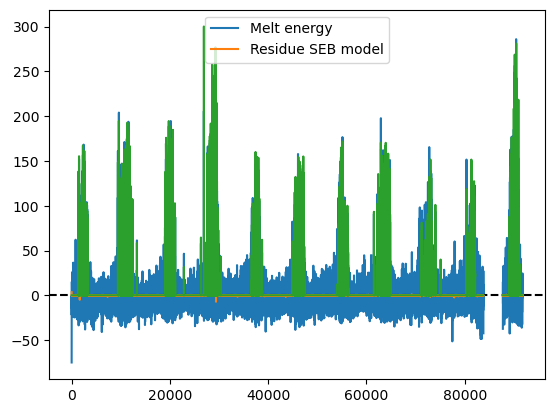

In [26]:

# plt.plot(Melt_energy, label='Melt energy+1k')
plt.plot(Melt_energy_no_melt, label='Melt energy')
plt.axhline(y=0, color='k', linestyle='--')
plt.plot(SEBdata.Extract_Variable('rest_energy'), label='Residue SEB model')
# plt.plot(np.array(Melt_energy) - np.array(Melt_energy_no_melt))
plt.plot(SEBdata.Extract_Variable('melt_energy'))
plt.legend()
# plt.ylim(-50, 50)

In [37]:
def plotter(SWdown, SWup, SWnet, LWdown, LWup, LWnet, SHF, LHF, Gs, MeltS,MeltT,Residu):
    
    PlotType = "Monthly"

    if PlotType == "AvgMonth":
        # Example of plotting the typical yearly cycle
        MyFunc = SEBf.get_avg_monthly_value
        Range  = [0, 12.5]
        Label  = "Month"
        Xdata  = np.arange(14)
    elif PlotType == "Monthly":
        # Example of montly averages
        MyFunc = SEBf.get_monthly_average
        Range  = [SEBdata.DateTime[0], SEBdata.DateTime[-1]]
        Label  = "Year"
        # do dummy call to function to get the date-times for the x-axis
        Xdata  = MyFunc(SHF, SEBdata.DateTime, GiveDatesBack=True)[1]
    elif PlotType == "Daily":
        # Example of montly averages
        MyFunc = SEBf.get_daily_average
        # restrain ourselves to one year, I take here 2016
        Range  = [dt.datetime.fromisoformat("2016-01-01"), dt.datetime.fromisoformat("2017-01-01")]
        Label  = "Date"
        # do dummy call to function to get the date-times for the x-axis
        Xdata  = MyFunc(SHF, SEBdata.DateTime, GiveDatesBack=True)[1]


    MonthSWdownS = MyFunc(SWdown, SEBdata.DateTime, PrintInfo=True)
    MonthSWupS   = MyFunc(SWup, SEBdata.DateTime)
    MonthSHFS    = MyFunc(SHF, SEBdata.DateTime)

    # however, it is easier to do the call to the SEBf-function in the plot call...

    fig, axs = plt.subplots(2, sharex=True)

    # upper figure are the radiative fluxes
    axs[0].plot(Xdata, MonthSWdownS, 'b', linewidth=0.5, label="$SW_{down}$")
    axs[0].plot(Xdata, -MonthSWupS, 'b:', linewidth=0.5, label="$SW_{up}$")
    if station == "S6":
        axs[0].plot(Xdata, MyFunc(-SWint, SEBdata.DateTime), 'b--', linewidth=0.5, label="$SW_{int}$")

    axs[0].plot(Xdata, MyFunc(LWdown, SEBdata.DateTime), 'r', linewidth=0.5, label="$LW_{down}$")
    axs[0].plot(Xdata, MyFunc(-LWup, SEBdata.DateTime), 'r:', linewidth=0.5, label="$LW_{up}$")
    axs[0].plot(Xdata, MyFunc(SWnet+LWnet, SEBdata.DateTime), 'k', linewidth=0.5, label="$R_{net}$")
    if station == "S6":
        axs[0].plot(Xdata, MyFunc(SWnet+LWnet-SWint, SEBdata.DateTime), 'k:', linewidth=0.5, label="$R_{net surf}$")
    axs[0].set_ylabel("Energy flux (W/m2)")
    axs[0].legend(loc='lower right') # well, no spot is nice
    axs[0].grid(True)

    if station == "S6":
        axs[1].plot(Xdata, MyFunc(SWnet-SWint, SEBdata.DateTime), 'b', linewidth=0.5, label="$SW_{net surf}$")
    else:
        axs[1].plot(Xdata, MyFunc(SWnet, SEBdata.DateTime), 'b', linewidth=0.5, label="$SW_{net}$")
    axs[1].plot(Xdata, MyFunc(LWnet, SEBdata.DateTime), 'r', linewidth=0.5, label="$LW_{net}$")
    axs[1].plot(Xdata, MyFunc(SHF, SEBdata.DateTime), 'seagreen', linewidth=0.5, label="$SHF$")
    axs[1].plot(Xdata, MyFunc(LHF, SEBdata.DateTime), 'orange', linewidth=0.5, label="$LHF$")
    axs[1].plot(Xdata, MyFunc(Gs, SEBdata.DateTime), 'grey', linewidth=0.5, label="$Gs$")
    axs[1].plot(Xdata, MyFunc(MeltS, SEBdata.DateTime), 'purple', linewidth=0.5, label="$M$")
    axs[1].plot(Xdata, MyFunc(Residu, SEBdata.DateTime), 'k', linewidth=0.5, label="Residue SEB model")

    axs[1].set_ylabel("Energy flux (W/m2)")
    axs[1].legend(loc='lower right') # Again, no spot is nice
    axs[1].set_xlabel(Label)
    axs[1].set_xlim(Range)
    axs[1].grid(True)

The date and hour of the first entry is April 05, 2009, 00:00.
First full month starts at May 01, 2009, 00:00
The date and hour of the last entry is September 23, 2019, 23:00.
Last full month end at August 31, 2019, 23:00
The dataset contains data of 125 months.


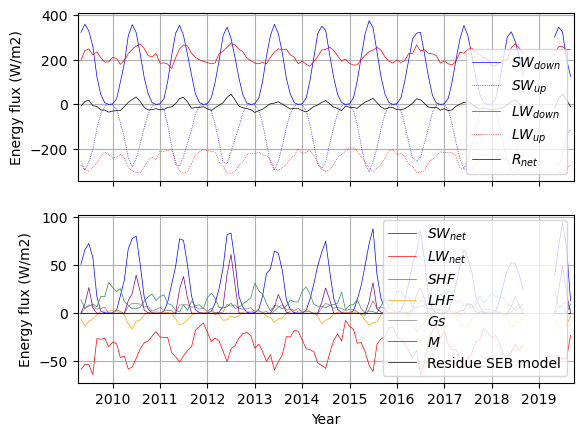

In [38]:
plotter(SWdown=SEBdata.Extract_Variable("SWin_corr"),SWup=SEBdata.Extract_Variable("SWout"),SWnet  = SEBdata.Extract_Variable("SWnet_corr"),LWdown = SEBdata.Extract_Variable("LWin"),LWup   = SEBdata.Extract_Variable("LWout_corr"),LWnet  = SEBdata.Extract_Variable("LWnet_model"),SHF    = SEBdata.Extract_Variable("Hsen"),LHF    = SEBdata.Extract_Variable("Hlat"), Gs     = SEBdata.Extract_Variable("Gs"), MeltS  = SEBdata.Extract_Variable("melt_energy") , MeltT  = SEBdata.Extract_Variable("totm_nrg") ,  Residu = SEBdata.Extract_Variable("rest_energy"))

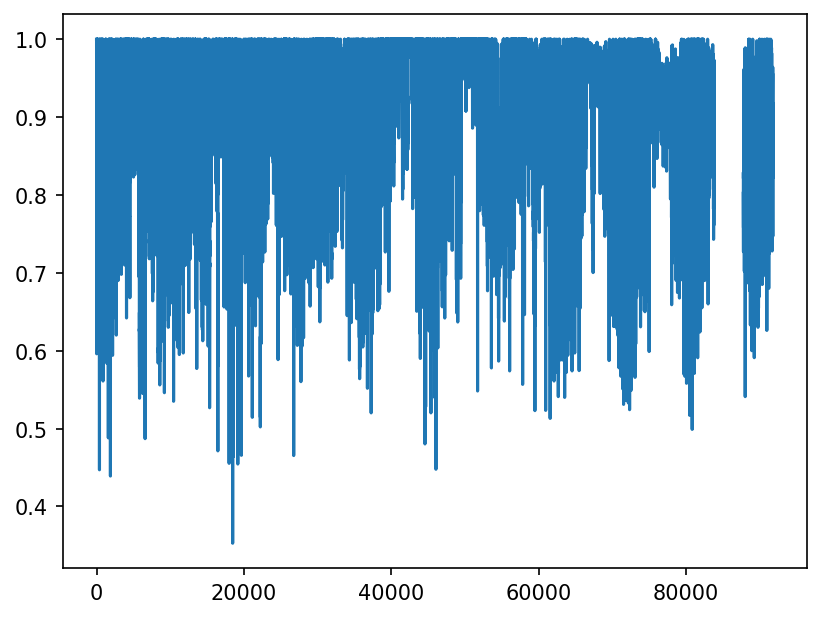

In [43]:
plt.figure(dpi=150)
plt.plot(SEBdata.Extract_Variable("RH")/100)

In [34]:
# Example, a simple adjustment: Increase LW down by making the apparent atmospheric temperature 1 K warmer

dtemp = 1.5 
Tsurf = SEBdata.Extract_Variable("Tsurf_calc")

LWmod = SEBf.convert_T_in_LWout(Tsurf) # this is the LWout from the model

LWout = LWnet - LWdown # this is the LWout from the observations
Tatm   = SEBf.convert_LWout_in_T(-LWdown, Celcius=False) # this is the apparent atmospheric temperature
LWinDT = -SEBf.convert_T_in_LWout(Tatm+dtemp, Celcius=False) # this is the LWdown for the +1K case

LWoutDTuc = LWnet - LWinDT # this is the LWout for the +1K case
TskinDT = SEBf.convert_LWout_in_T(LWoutDTuc) # this is the skin temperature for the +1K case
TskinDT = np.where(TskinDT>0., 0., TskinDT) # make sure we do not get positive skin temperatures
LWoutDT = SEBf.convert_T_in_LWout(TskinDT) # this is the LWout for the +1K case
MeltTDT = MeltT + LWoutDT - LWoutDTuc # this is the melt for the +1K case in units of?? (meltT should be  also w/m^2 + since w/m^2 - w/m^2)

fig2, ax2 = plt.subplots()
ax2.plot(SEBdata.DateTime, SEBf.get_running_melt_sum(MeltTDT, SEBdata.TimeStep), 'r', label='Melt for +1K') 
ax2.plot(SEBdata.DateTime, SEBf.get_running_melt_sum(MeltT,   SEBdata.TimeStep), 'g', label='Observed Melt')
ax2.legend(loc='upper left')
ax2.set_ylabel('Accumulated melt (m w.e.)')
ax2.set_xlabel('Year')
ax2.set_xlim([SEBdata.DateTime[0], SEBdata.DateTime[-1]])
ax2.set_ylim([0, 19])


NameError: name 'LWnet' is not defined

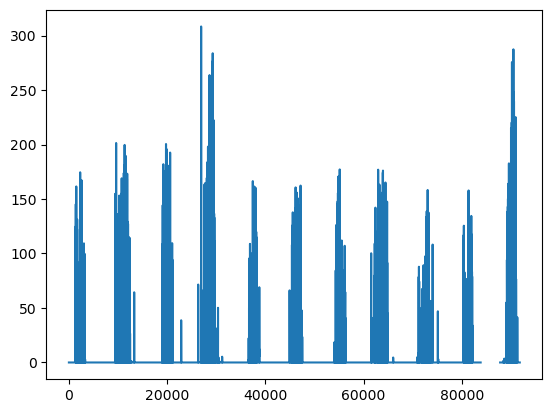

In [ ]:
plt.plot(MeltTDT)